## Import necessary dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import IPython.display as ipd
from tqdm import tqdm_notebook
import wave
from scipy.io import wavfile
sample_rate = 44100

import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls

import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import os
import librosa.display

import warnings
warnings.filterwarnings('ignore')

## Audio

### Duration
The length of the audio in terms of time

### Sampling Rate
The number of samples of audio per second, measured in Hz or KHz. This is similar to resolution in images, where the higher the resolution (or more pixels), the clearer it is

### Amplitude
Fluctuation of the sound wave

### Frequency
Frequency, albeit a little less intuitive is much more efficient in terms of computational space requirement

In [2]:
INPUT_LIB = 'input/'
audio_train_files = os.listdir('input/audio_train')
audio_test_files = os.listdir('input/audio_test')
train = pd.read_csv('input/train.csv',index_col=None)
test = pd.read_csv("input/sample_submission.csv", index_col=None)
train_audio_path = 'input/audio_train/'
filename = '/001ca53d.wav'
samples, SAMPLE_RATE = librosa.load(str(train_audio_path)+filename)
# SAMPLE_RATE = 16000

### librosa.feature

Feature extraction and manipulation. This includes low-level feature extraction, such as chromograms, Mel Spectrogram, MFCC, and various other spectral and rhythmic features

## Mel Spectrogram

How to get a mel spectrogram?
1. Compute short-term/windowed fourier transform over the signal.
2. This should give you multiple fourier outputs for different windows of the signal. Stack the outputs on top of each other to get a spectrogram (Look closely at the different axes)
3. The y-axis is converted to a log scale, and the color dimension is converted to decibels
4. Map the y-axis onto the mel scale to form a mel spectrogram 

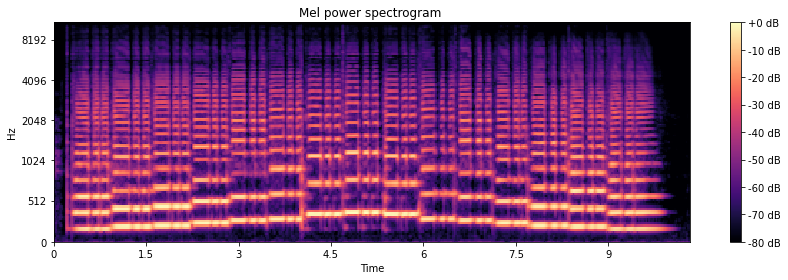

In [3]:
S = librosa.feature.melspectrogram(samples, sr=SAMPLE_RATE, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [4]:
print("Size of training data",train.shape)

Size of training data (9473, 3)


### MFCC (Mel Frequency Cepstral Co-efficients)

Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

[[-5.2449506e+02 -5.2041772e+02 -5.2132574e+02 ... -6.0583795e+02
  -6.0232983e+02 -6.0881934e+02]
 [ 7.2463425e+01  7.6269432e+01  7.7269875e+01 ...  1.4340765e+01
   1.8563709e+01  1.0479044e+01]
 [-1.6316036e+01 -1.7810047e+01 -1.4198684e+01 ...  1.2207654e+01
   1.4874502e+01  9.0235672e+00]
 ...
 [-2.8327274e+00 -2.9343605e+00 -3.7258608e+00 ...  4.0633634e-01
   3.0309911e+00  3.2080755e+00]
 [ 5.1598887e+00  6.1620512e+00  4.3228626e+00 ...  8.6948186e-01
   3.6675620e+00  3.6422462e+00]
 [ 9.2251549e+00  8.7090454e+00  4.2673445e+00 ...  1.6132598e+00
   3.4886003e+00  3.6067648e+00]]


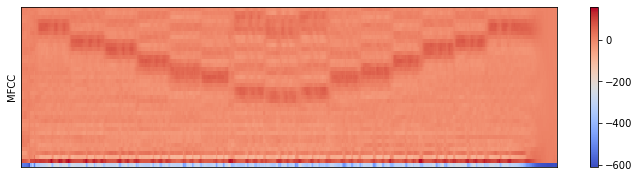

In [5]:
mfcc = librosa.feature.mfcc(samples, sr = SAMPLE_RATE, n_mfcc=40)
print(mfcc)
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

### Harmonic Percussive source separation

This feature separates the harmonic and the percussive source of an audio file.

In [6]:
y_harmonic, y_percussive = librosa.effects.hpss(samples)
ipd.Audio(y_harmonic, rate=SAMPLE_RATE)

In [7]:
ipd.Audio(y_percussive, rate=SAMPLE_RATE)

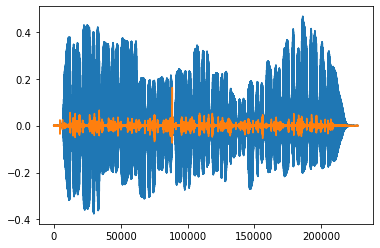

In [8]:
plt.plot(y_harmonic)
plt.plot(y_percussive)

### Chroma

[[0.51671963 0.76791568 1.         ... 0.88648618 1.         1.        ]
 [1.         0.44280282 0.65592323 ... 1.         0.93668232 0.70008777]
 [0.77089566 0.72619677 0.5371256  ... 0.67870414 0.59682431 0.41896176]
 ...
 [0.72644757 0.88436171 0.81702055 ... 0.52449024 0.76946394 0.69685125]
 [0.34727835 1.         0.95591327 ... 0.56300983 0.68338676 0.67954909]
 [0.52122795 0.77474355 0.96713116 ... 0.4542233  0.52172578 0.48773112]]


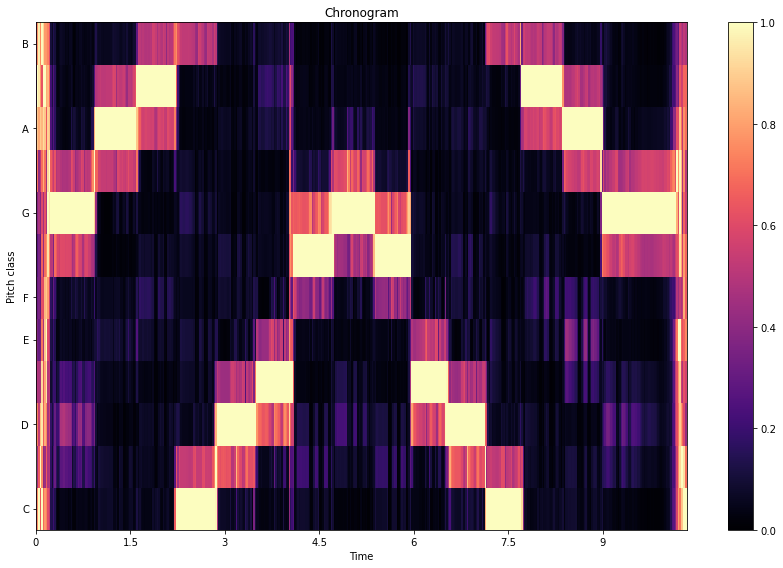

In [9]:
C = librosa.feature.chroma_cqt(samples, sr=SAMPLE_RATE)
print(C)
plt.figure(figsize=(12,8))
librosa.display.specshow(C, sr=SAMPLE_RATE, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chronogram')
plt.colorbar()
plt.tight_layout()

## MISC [IGNORE]


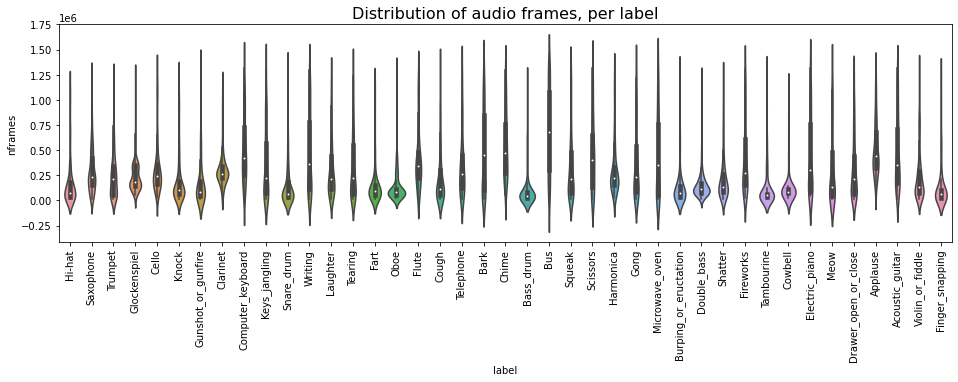

In [10]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('input/audio_train/' + f).getnframes())
#test['nframes'] = test['fname'].apply(lambda f: wave.open('input/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

In [11]:
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [12]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)
            
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X
        
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

In [13]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [14]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

NameError: name 'COMPLETE_RUN' is not defined